In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
import random
import math
import time 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from indicnlp.tokenize import indic_tokenize
from torchtext import data
from torchtext.data import Field, BucketIterator
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install indic-nlp-library

In [3]:
df = pd.read_csv('./train.txt', delimiter = "\t", header = None)
df.rename(columns = {0 : 'english', 1 : 'hindi'}, inplace = True)
en_tokenizer = spacy.load('en_core_web_sm')
df

,english,hindi
0,Batman vs Superman,batman vs superman
1,"The director is Zack Snyder, 27% Rotten Tomato...","Zack Snyder director hai, 27% Rotten Tomatoes,..."
2,Not very popular it seems,lagta hai bahut popular nahi hai
3,But the audiences liked it. It has a B cinema ...,"but audience ne like kiya, iska cinema score B..."
4,Yes,yes
...,...,...
8055,Ok.,Thik hai
8056,ok bro,Thik hai bhai
8057,shall we continue?,Kya ham chalu kar sakte hai?
8058,do you like we can,Kya aapko pasand hai hamare saath


In [4]:

# train_temp, test_data_sent = train_test_split(df, test_size = 0.2)
# train_data_sent, validation_data_sent = train_test_split(train_temp, test_size=0.125)
# train_data_sent
# df=df.iloc[:10]
train_data_sent, test_data_sent = train_test_split(df, test_size = 0.2)
validation_data_sent = pd.read_csv('./dev.txt', delimiter = "\t", header = None)
validation_data_sent.rename(columns = {0 : 'english', 1 : 'hindi'}, inplace = True)
# train_data_sent
# validation_data_sent=validation_data_sent.iloc[:5]
validation_data_sent

,english,hindi
0,hello,hello
1,"hello there, I have not seen this movie so im ...","hello yar, mein is movie ko nahi dekha hoon th..."
2,Alright that is fine. What is the movie?,acha tho is movie kis baare me hein?
3,The movie is The Social Network,is movie tho social network ke bare mein hein
4,I have not seen that one either.,mein aise kuch nahi dekha hoon
...,...,...
937,Yep. Thanks for chatting,Yep. Thanks baat karne ke liye
938,"thanks, I will watch it. SOunds good","Thanks, mei dekhati hui. Achi baat hai"
939,Hi!,Hi!
940,Did you like the movie Despicable Me?,kya tumhe movie Despicable Me pasand hai?


In [5]:
train_data_sent.to_json('train_data.json', orient='records', lines=True)
validation_data_sent.to_json('validation_data.json', orient='records', lines=True)
test_data_sent.to_json('test_data.json', orient='records', lines=True)

In [6]:
def hindi_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]    
#     return [word for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip())]

In [7]:
def english_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]

In [8]:
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>' , lower = True)
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

In [9]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

print(len(train_data), len(validation_data), len(test_data))

6448 942 1612


In [10]:
# print(train_data_sent)
print(vars(train_data.examples[0]))

{'english': ['what', "'s", 'it', 'about', '?'], 'hindi': ['kiske', 'baare', 'mein', 'hai', '?']}


In [11]:
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)

print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 3181, Hindi: 4064


In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(input_size, embedding_size) 
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, input):
        embeddings = self.dropout(self.word_embeddings(input)) # shape will be sentence_length x batch_size x embedding_size
        o, (h, c) = self.lstm(embeddings) # output shape will be sentence_length x batch_size x hidden size, hidden shape will be 1 x batch_size x hidden_size because we are returning only the final hidden layer

        return h, c

In [ ]:
class Attention(nn.Module):
    def __init__(self, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((dec_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size)
        self.linear = nn.Linear(embedding_size + hidden_size + hidden_size, output_size)
        self.output_size = output_size
        self.hidden_size = hidden_size

    def forward(self, input, h, c, z):        
        embeddings = self.dropout(self.word_embeddings(input)) # shape will be 1 x batch_size x embedding_size
        o, (h, c) = self.lstm(torch.cat((embeddings, z), dim = 2), (h, c)) # shape will be 1 x batch_size x hidden_size
        predictions = self.linear(torch.cat((embeddings, h, z), dim = 2).squeeze(0)) # both shapes will be batch_size x output_vocabulary_size

        return predictions, h, c

In [14]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
         
    def forward(self, input, actual):
        
        h, c = self.encoder(input)
        z = h
        input = actual[0, :]
        predictions = torch.zeros(actual.shape[0], actual.shape[1], self.decoder.output_size).to(self.device)

        for t in range(1, actual.shape[0]):
            o, h, c = self.decoder(input.unsqueeze(0), h, c, z)
            predictions[t] = o
            predicted = o.argmax(1) 
            input = predicted

        return predictions

In [15]:
# a = 4
# b = a
# a = 6
# a += 1
# print(a, b)

In [16]:
def train(model, train_data_iterator, optimizer, criterion):
    
    model.train()    
    total_loss = 0
    
    for batch in train_data_iterator:
        input = batch.english
        actual = batch.hindi
        optimizer.zero_grad()
        predictions = model(input, actual)
        vocab_size = predictions.shape[-1]
        predictions = predictions[1:].view(-1, vocab_size)
        actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
        loss = criterion(predictions, actual)
        loss.backward()   
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    average_loss = total_loss / len(train_data_iterator)
    return average_loss

In [17]:
def evaluate(model, data_iterator, criterion):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_iterator:
            input = batch.english
            actual = batch.hindi
            predictions = model(input, actual)
            vocab_size = predictions.shape[-1]
            predictions = predictions[1:].view(-1, vocab_size)
            actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
            loss = criterion(predictions, actual)
            total_loss += loss.item()
    
    average_loss = total_loss / len(data_iterator)
    return average_loss

In [18]:
enc = Encoder(len(ENGLISH.vocab), 350, 512, 0.5)
dec = Decoder(len(HINDI.vocab), 350, 512, 0.5)

model = Model(enc, dec, device).to(device)
for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)
model

Model(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(3181, 350)
    (lstm): LSTM(350, 512)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(4064, 350)
    (lstm): LSTM(862, 512)
    (linear): Linear(in_features=1374, out_features=4064, bias=True)
  )
)

In [19]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = HINDI.vocab.stoi[HINDI.pad_token])

In [20]:
best_loss = 1e9

train_data_iterator, validation_data_iterator, test_data_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)

training_losses = []
validation_losses = []

for epoch in range(25):
    train_loss = train(model, train_data_iterator, optimizer, criterion)
    valid_loss = evaluate(model, validation_data_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'encoder_decoder.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f"Train Loss (exponent to analyse better): {np.exp(train_loss):.3f}")
    print(f"Val. Loss (exponent to analyse better): {np.exp(valid_loss):.3f}")

Epoch: 01
	Train Loss: 6.161 | Train PPL: 473.951
	 Val. Loss: 5.653 |  Val. PPL: 285.263
Train Loss (exponent to analyse better): 473.951
Val. Loss (exponent to analyse better): 285.263
Epoch: 02
	Train Loss: 5.912 | Train PPL: 369.573
	 Val. Loss: 5.635 |  Val. PPL: 280.038
Train Loss (exponent to analyse better): 369.573
Val. Loss (exponent to analyse better): 280.038
Epoch: 03
	Train Loss: 5.848 | Train PPL: 346.506
	 Val. Loss: 5.647 |  Val. PPL: 283.360
Train Loss (exponent to analyse better): 346.506
Val. Loss (exponent to analyse better): 283.360
Epoch: 04
	Train Loss: 5.772 | Train PPL: 321.309
	 Val. Loss: 5.519 |  Val. PPL: 249.277
Train Loss (exponent to analyse better): 321.309
Val. Loss (exponent to analyse better): 249.277
Epoch: 05
	Train Loss: 5.691 | Train PPL: 296.224
	 Val. Loss: 5.497 |  Val. PPL: 243.926
Train Loss (exponent to analyse better): 296.224
Val. Loss (exponent to analyse better): 243.926
Epoch: 06
	Train Loss: 5.635 | Train PPL: 280.043
	 Val. Loss: 5.

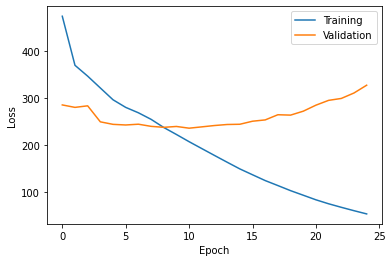

In [26]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
model.load_state_dict(torch.load('encoder_decoder.pt'))
test_loss = evaluate(model, test_data_iterator, criterion)
print(f"Test Loss (exponent to analyse better): {np.exp(test_loss):.3f}")

Test Loss (exponent to analyse better): 243.475


In [29]:
# vars(test_data.examples[2])

In [30]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaking native language:"))

['namaskaar', 'mujhe', ',', '<unk>', '<unk>', '<eos>', '<eos>']


In [31]:
import csv

translated_sentences = open('Paper1.csv','w')
csvwriter = csv.writer(translated_sentences)
csvwriter.writerow(['Input','Predicted','Actual'])  

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

translated_sentences.close()



In [32]:
with open('Paper1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} \t \t {row[1]} \t \t {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are Input, Predicted, Actual
	well all depends on the movie 	 	 mujhe , <unk> <unk> hai 	 	 Achhee tarah se sabhee movie ko nirbhar karata hai.
	oh nice. Who is Gru voiced by? 	 	 mujhe , <unk> <unk> <unk> 	 	 ohnice. Gru kisne voice kiya hai.
	yea it works out pretty well 	 	 mujhe , <unk> <unk> <unk> 	 	 yea it works out pretty well.
	Yes I watched the whole movie. 	 	 mujhe , <unk> <unk> 	 	 yes mene whole movie dekhi..
	It had me on the edge of my seat, I also had no idea. 	 	 mujhe , hai <unk> , <unk> <unk> <unk> <unk> <unk> <unk> <unk> 	 	 isne mujhe apni seat ki edge par la diya, mujhe bhi koi idea nahi tha..
	Definitely! You too! 	 	 <unk> bhi 	 	 Definitely! tum bhi!.
	S I LIKE THIS FILM 	 	 mujhe , <unk> <unk> 	 	 mujhe ye film pasand hai.
	I think he and Rachel McAdams had fine performances! 	 	 mujhe , <unk> <unk> <unk> <unk> <unk> 	 	 Muje lagta he ki wo aur Rachel MaAdamas ne acha perform kiya.
	Wolf of Wall street is pretty famous in the US. 	 	 mujhe , <unk

In [1]:
# import csv

# translated_sentences = open('Paper2.csv','w')
# csvwriter = csv.writer(translated_sentences)
# csvwriter.writerow(['Input','Predicted','Actual'])  

import nltk

bleu_i = []
bleu_o = []

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  # csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  bleu_i.append(hin_sentence.strip())
  bleu_o.append(hindi_predicted.strip())

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

# translated_sentences.close()

BLEU_scores = []

for i in range(len(bleu_i)):
  BLEU_scores.append(nltk.translate.bleu_score.sentence_bleu(bleu_i[i], bleu_o[i], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7))
  
print("Average BLEU Score:", np.mean(BLEU_scores))



Average BLEU Score: 0.0322889663350351
